In [223]:
import pandas as pd 
#import pandas_datareader as pdr  
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb 
import math
from backtesting import *
from backtesting.test import SMA


## Get data

In [224]:
# ticker = input("Enter the ticker of the stock you want to analyze (i.e. ^SPX, AAPL): ")
# start = input("Enter the starting date for daily returns data in format YYYY-MM-DD")
# end = input("Enter the ending date for daily returns data in format YYYY-MM-DD")
ticker = "IBM"
start = "2015-01-01"
end = "2023-01-01"

return_type = "Adj Close"

In [225]:
raw_data = yf.download(ticker, start , end)
raw_data.head()

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-02  154.216064  156.128113  153.919693  154.933075  102.338921   
2015-01-05  154.177826  154.177826  152.189301  152.495224  100.728615   
2015-01-06  152.648178  152.925430  148.346085  149.206497   98.556328   
2015-01-07  150.286804  150.286804  147.256210  148.231354   97.912193   
2015-01-08  149.369019  152.045883  148.709366  151.453156  100.040283   

             Volume  
Date                 
2015-01-02  5779673  
2015-01-05  5104898  
2015-01-06  6429448  
2015-01-07  4918083  
2015-01-08  4431693

## Adding columns in data 
### returns, moving averages, rolling standard deviations, and ratio of returns to moving average

In [226]:
ma_length = 60
data = raw_data.copy()
data['returns'] = np.log(data[return_type].diff())  # add column with log returns
data['ma'] = data[return_type].rolling(ma_length).mean() # add column with moving average
data['std'] = data[return_type].rolling(ma_length).std() # add column with moving standard deviation
data['ratio'] = data[return_type] / data['ma'] # add column with ratio of price to moving average

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [227]:
data['ratio'].describe() # expecting mean to be around 1, so that data seems to be mean reverting

count    1955.000000
mean        1.004901
std         0.059013
min         0.707211
25%         0.969349
50%         1.005492
75%         1.044482
max         1.162412
Name: ratio, dtype: float64

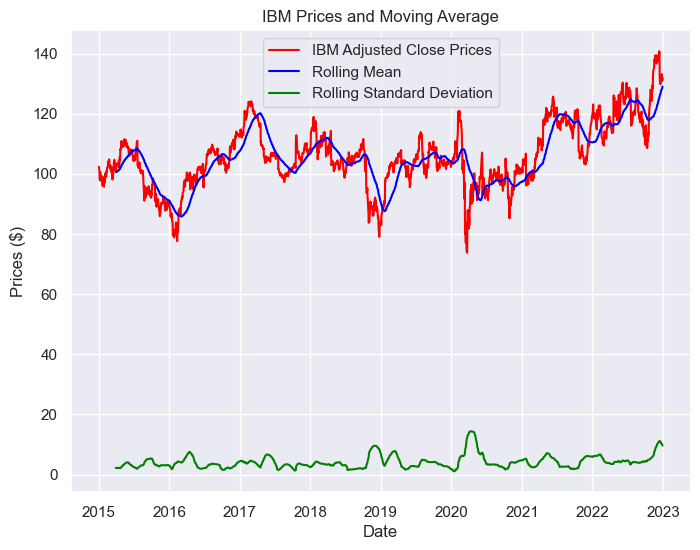

In [228]:
plt.plot(data[return_type], label=f'{ticker} Adjusted Close Prices', color='red')
plt.plot(data['ma'], label=f'Rolling Mean', color='blue')
plt.plot(data['std'], label=f'Rolling Standard Deviation', color='green')
plt.title(f'{ticker} Prices and Moving Average')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()
plt.grid(True)
plt.show()

## Moving average percentile analysis

In [229]:
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(data['ratio'].dropna(), percentiles)

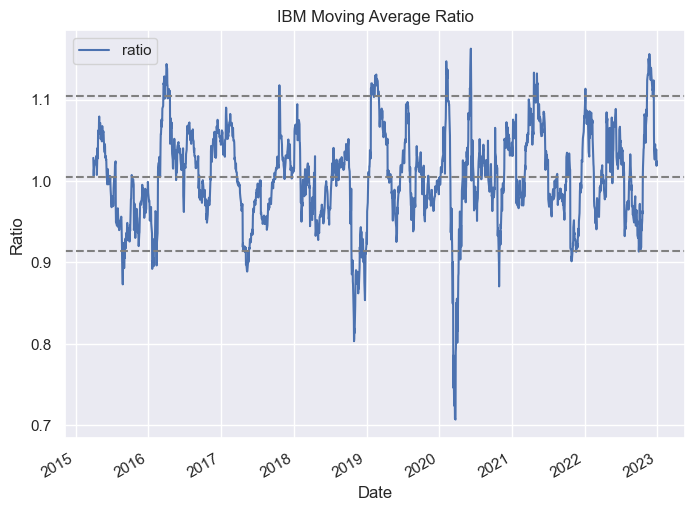

In [230]:
data['ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')
plt.legend()
plt.title(f'{ticker} Moving Average Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

In [231]:
class MeanReversion(Strategy):
    ma_length = 30
    
    def init(self):
        # Simple moving average and ratio of price to SMA
        self.offset = 0.01
        self.prices = self.data['Close']
        self.ma = self.I(self.compute_rolling_mean, self.prices, self.ma_length)
        
    def compute_rolling_mean(self, prices, window): # Function to compute rolling mean
        return [(sum(prices[max(0, i - window):i]) / min(i, window)) if i > 0 else np.nan for i in range(len(prices))]
        
    def next(self):
        size = 0.1 # Trading 10% of the portfolio each time
        
        # If price drops to more than offset% below n1-day moving average, buy
        if self.data['Close'] < self.ma[-1] * (1 - self.offset):
            print(f"Buying at {self.data['Close']}")
            if self.position.size < 0:  # Check for existing short position
                self.buy()  # Close short position
            self.buy(size=size)

        # If price rises to more than offset% above n1-day moving average, sell
        elif self.data['Close'] > self.ma[-1] * (1 + self.offset):
            print(f"Selling at {self.data['Close']}")
            if self.position.size > 0:  # Check for existing long position
                self.sell()  # Close long position
            self.sell(size=size)



## Try backtesting using the imported package

In [232]:
bt = Backtest(raw_data, MeanReversion, cash = 100000, commission = 0.002)
stats = bt.run()
bt.plot()
print(stats)

Buying at [154.93307495 152.495224   149.20649719]
Buying at [154.93307495 152.495224   149.20649719 148.23135376]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823 149.56022644]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823 149.56022644 149.91395569 148.94837952]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823 149.56022644 149.91395569 148.94837952 147.77246094]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823 149.56022644 149.91395569 148.94837952 147.77246094
 150.22944641 150.04780579 145.40153503]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823 149.56022644 149.91395569 148.94837952 147.77246094
 150.22944641 150.04780579 145.40153503 148.55641174 149.01528931
 149.48374939 146.91204834]
Buying at [154.93307495 152.495224   149.20649719 148.23135376 151.45315552
 152.11280823

/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values 

Start                     2015-01-02 00:00:00
End                       2022-12-30 00:00:00
Duration                   2919 days 00:00:00
Exposure Time [%]                   99.851043
Equity Final [$]                215950.326866
Equity Peak [$]                 226267.755381
Return [%]                         115.950327
Buy & Hold Return [%]               -9.063962
Return (Ann.) [%]                   10.112275
Volatility (Ann.) [%]                24.05098
Sharpe Ratio                         0.420452
Sortino Ratio                         0.70408
Calmar Ratio                         0.287706
Max. Drawdown [%]                  -35.147951
Avg. Drawdown [%]                   -4.002909
Max. Drawdown Duration      689 days 00:00:00
Avg. Drawdown Duration       50 days 00:00:00
# Trades                                 1519
Win Rate [%]                        72.021066
Best Trade [%]                       25.69997
Worst Trade [%]                    -15.854292
Avg. Trade [%]                    